In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sympy as sp

In [9]:
def discretize_EDE(f_drift, g_diffusion, method='euler'):
    """
    Discretiza una EDE usando el método de Euler-Maruyama o Milstein.
    """
    Xt_prev = sp.Symbol('X_ti_minus_1')
    dt = sp.Symbol('Delta_ti')
    dB = sp.Symbol('Delta_Bi')

    f_eval = f_drift.subs({'X_t': Xt_prev})
    g_eval = g_diffusion.subs({'X_t': Xt_prev})

    euler_update = Xt_prev + f_eval * dt + g_eval * dB

    if method == 'euler':
        return euler_update
    elif method == 'milstein':
        g_prime = sp.diff(g_diffusion, 'X_t').subs({'X_t': Xt_prev})
        milstein_update = euler_update + (1/2) * g_prime * g_eval * (dB**2 - dt)
        return milstein_update
    else:
        raise ValueError("Método no reconocido. Usa 'euler' o 'milstein'.")

def simulate_EDE(mu, sigma, X0, T, n_steps, method='euler', seed=None):
    """
    Simula una trayectoria de la EDE usando Euler-Maruyama o Milstein.

    Parámetros:
    -----------
    mu, sigma : float
        Parámetros de la EDE: dXt = mu Xt dt + sigma Xt dBt
    X0 : float
        Valor inicial.
    T : float
        Tiempo final.
    n_steps : int
        Número de pasos.
    method : str
        'euler' o 'milstein'
    seed : int
        Semilla para reproducibilidad.

    Retorna:
    --------
    times, trajectory
    """
    if seed is not None:
        np.random.seed(seed)

    # Definimos símbolos
    X_t = sp.Symbol('X_t')
    f_drift = mu * X_t
    g_diffusion = sigma * X_t

    # Discretización
    update_rule = discretize_EDE(f_drift, g_diffusion, method=method)

    # Compilamos la función para rápido
    Xt_prev = sp.Symbol('X_ti_minus_1')
    dt = sp.Symbol('Delta_ti')
    dB = sp.Symbol('Delta_Bi')
    update_func = sp.lambdify((Xt_prev, dt, dB), update_rule, "numpy")

    # Inicializamos
    dt_value = T / n_steps
    times = np.linspace(0, T, n_steps + 1)
    X = np.zeros(n_steps + 1)
    X[0] = X0

    # Simulación
    for i in range(1, n_steps + 1):
        dB_value = np.random.normal(0, np.sqrt(dt_value))
        X[i] = update_func(X[i-1], dt_value, dB_value)

    return times, X

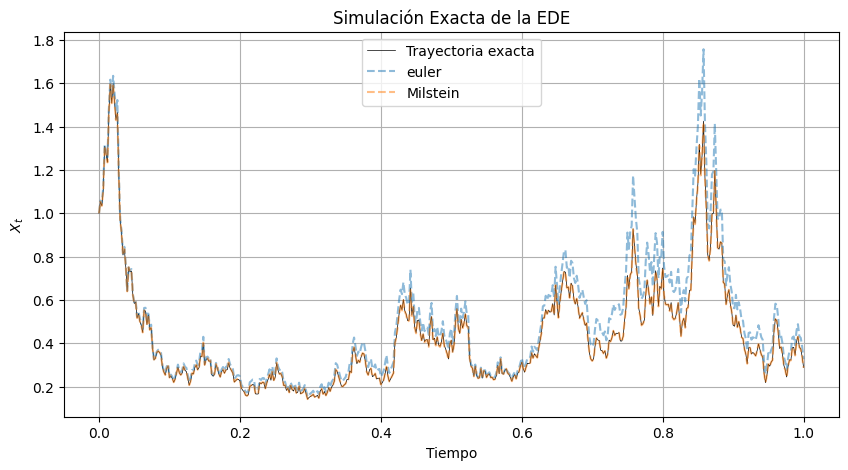

In [28]:
def simulate_exact_solution(mu, sigma, X0, T, n_steps, seed=None):
    """
    Simula la trayectoria exacta de la EDE.

    Parámetros:
    -----------
    mu, sigma : float
        Parámetros de la EDE.
    X0 : float
        Valor inicial.
    T : float
        Tiempo final.
    n_steps : int
        Número de pasos.
    seed : int
        Semilla aleatoria.

    Retorna:
    --------
    times : np.array
        Puntos de tiempo.
    Xt : np.array
        Trayectoria simulada de X_t.
    """

    if seed is not None:
        np.random.seed(seed)

    dt = T / n_steps
    times = np.linspace(0, T, n_steps + 1)

    # Simular B_t
    dB = np.random.normal(0, np.sqrt(dt), size=n_steps)
    B = np.zeros(n_steps + 1)
    B[1:] = np.cumsum(dB)

    # Aplicar fórmula exacta
    Xt = X0 * np.exp((mu - 0.5 * sigma**2) * times + sigma * B)

    return times, Xt


# Parámetros
mu = 1.5
sigma = 2.5
X0 = 1.0
T = 1
n_steps = 500


# Milstein approximation
times, aprox_em = simulate_EDE(mu, sigma, X0, T, n_steps, method='euler', seed=42)
# Euler-Maruyama approximation
times, aprox_m = simulate_EDE(mu, sigma, X0, T, n_steps, method='milstein', seed=42)
# Exact solution simulation
times, exact_sim = simulate_exact_solution(mu, sigma, X0, T, n_steps, seed=42)

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(times, exact_sim, label='Trayectoria exacta', color='k', linewidth=0.5)
plt.plot(times, aprox_em, label='euler', linestyle='--', alpha=0.5)
plt.plot(times, aprox_m, label='Milstein', linestyle='--', alpha=0.5)
plt.xlabel('Tiempo')
plt.ylabel('$X_t$')
plt.title('Simulación Exacta de la EDE')
plt.grid(True)
plt.legend()
plt.show()
